# Background handling

We experiment with background modeling and subtraction. Initial goal is to allow peak finding over the entire image with a single set of parameters. Eventually we will use results gleaned from here, to build the background-handling pipeline step.

In [1]:
%pylab notebook
%matplotlib notebook
import os, glob
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import rawpy

Populating the interactive namespace from numpy and matplotlib


In [2]:
fname = '../astrophotography_data/MilkyWayPrettyBoy/tests/12800_DSC03779.ARW'

In [3]:
raw = rawpy.imread(fname)
rgb = raw.postprocess()

red = rgb[::,::,0]
green = rgb[::,::,1]
blue = rgb[::,::,2]

red1 = red # * raw.camera_whitebalance[0] / raw.camera_whitebalance[1]
green1 = green
blue1 = blue # * raw.camera_whitebalance[2] / raw.camera_whitebalance[1]

gray_rgb_image = red1/3. + green1/3. + blue1/3.

<IPython.core.display.Javascript object>


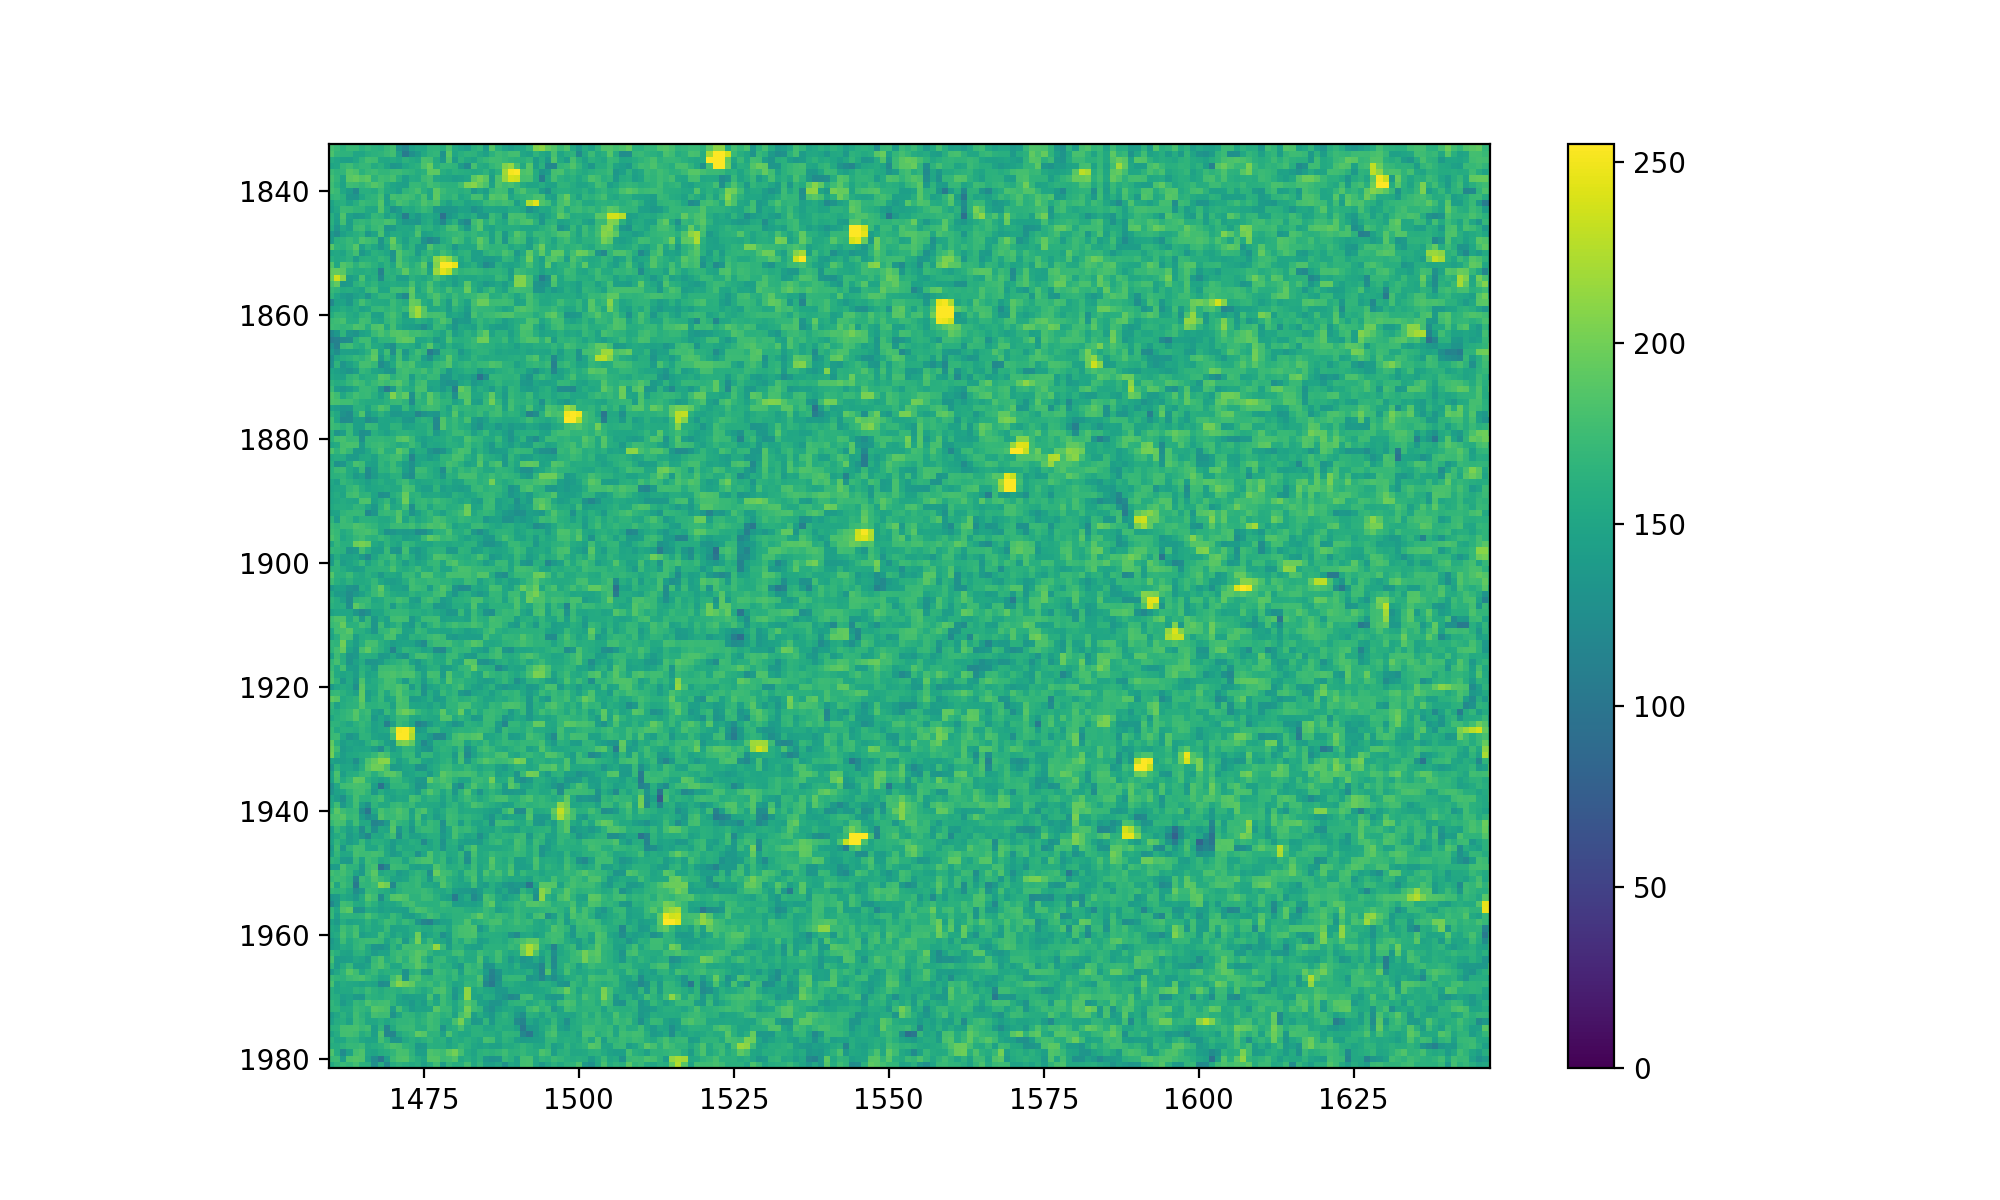

In [4]:
plt.figure(figsize=[10, 6])
plt.imshow(gray_rgb_image)
plt.colorbar()

In [5]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(gray_rgb_image, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

<IPython.core.display.Javascript object>


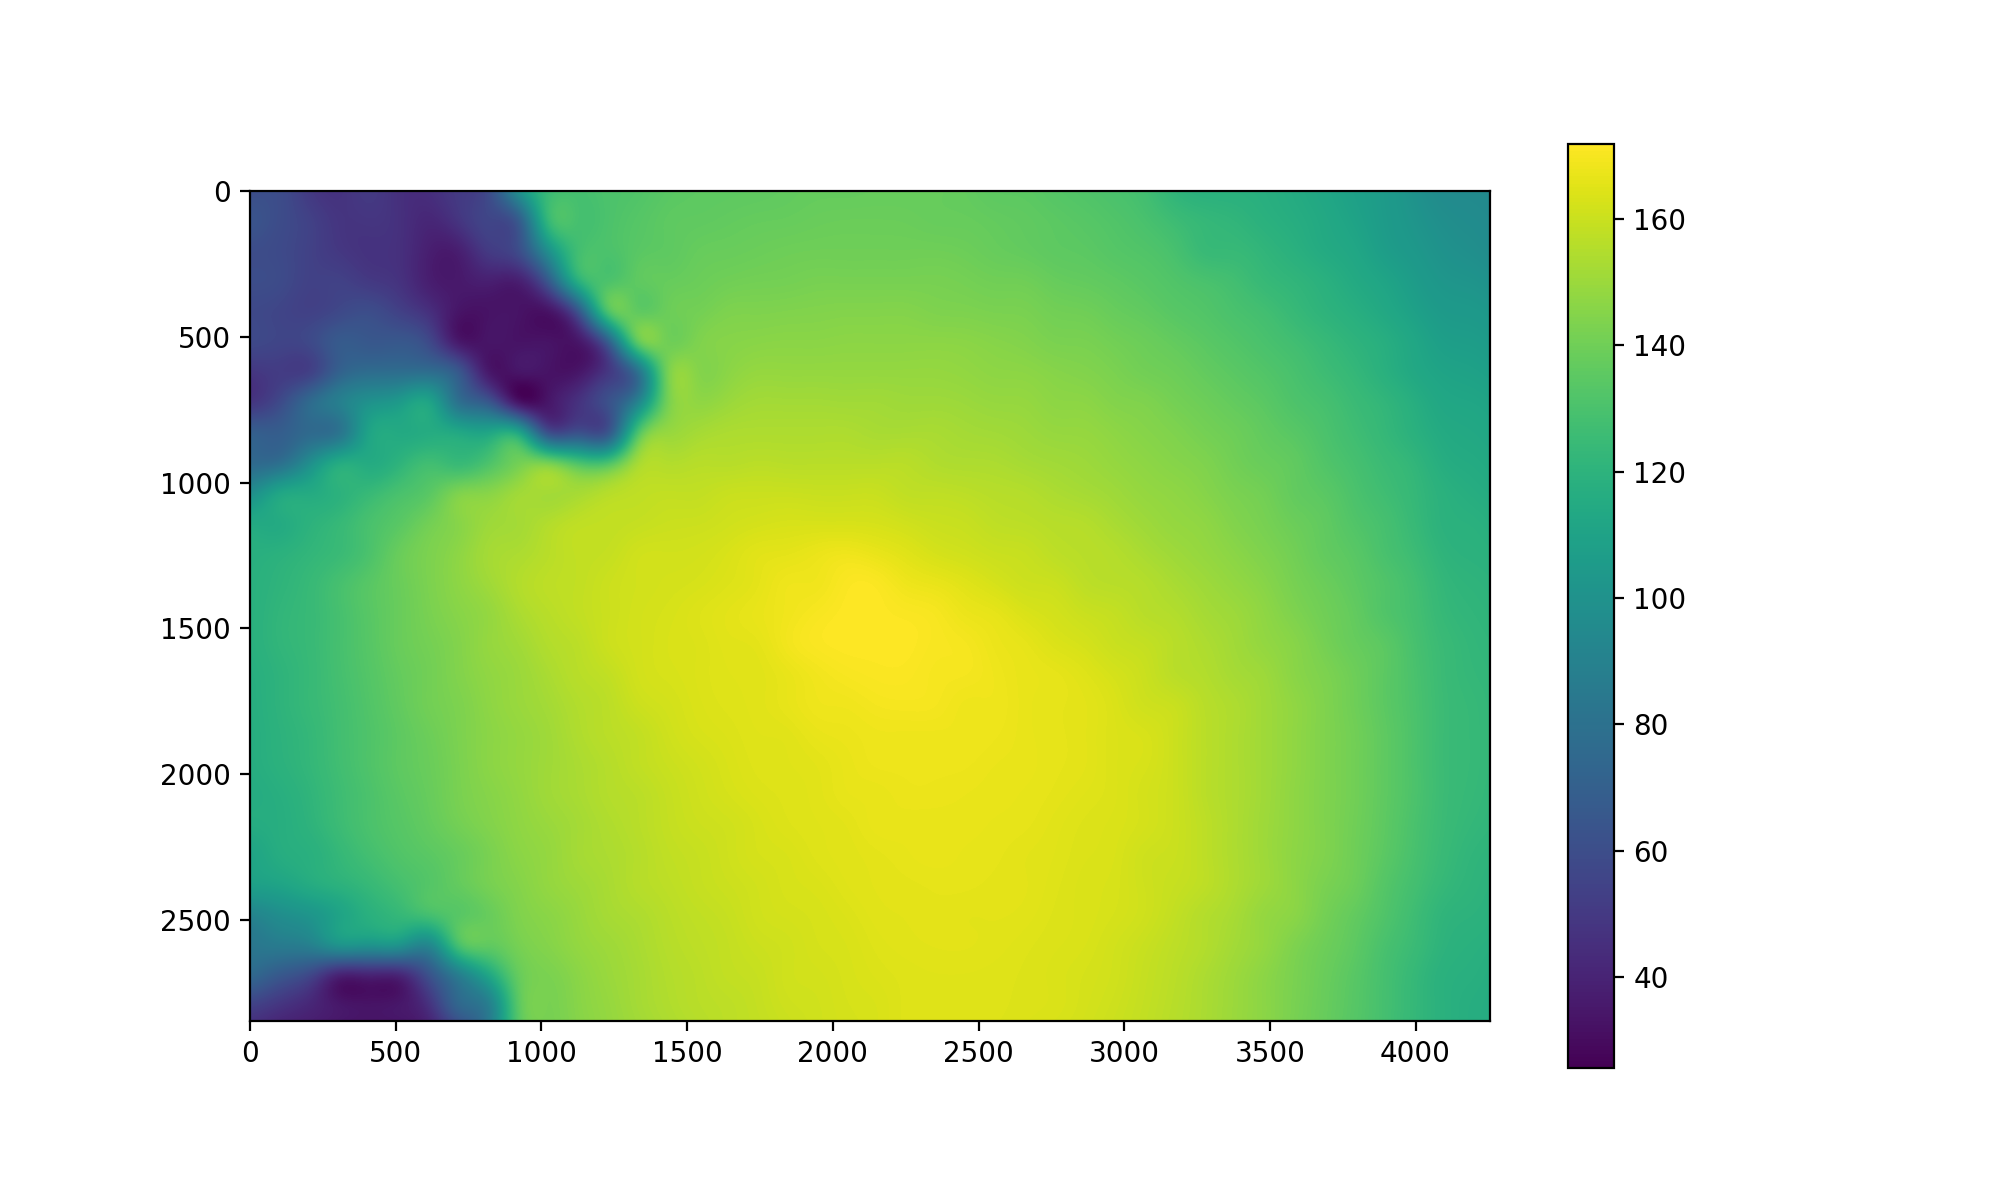

In [6]:
plt.figure(figsize=[10, 6])
plt.imshow(bkg.background)
plt.colorbar()

In [7]:
subtracted = gray_rgb_image - bkg.background

<IPython.core.display.Javascript object>


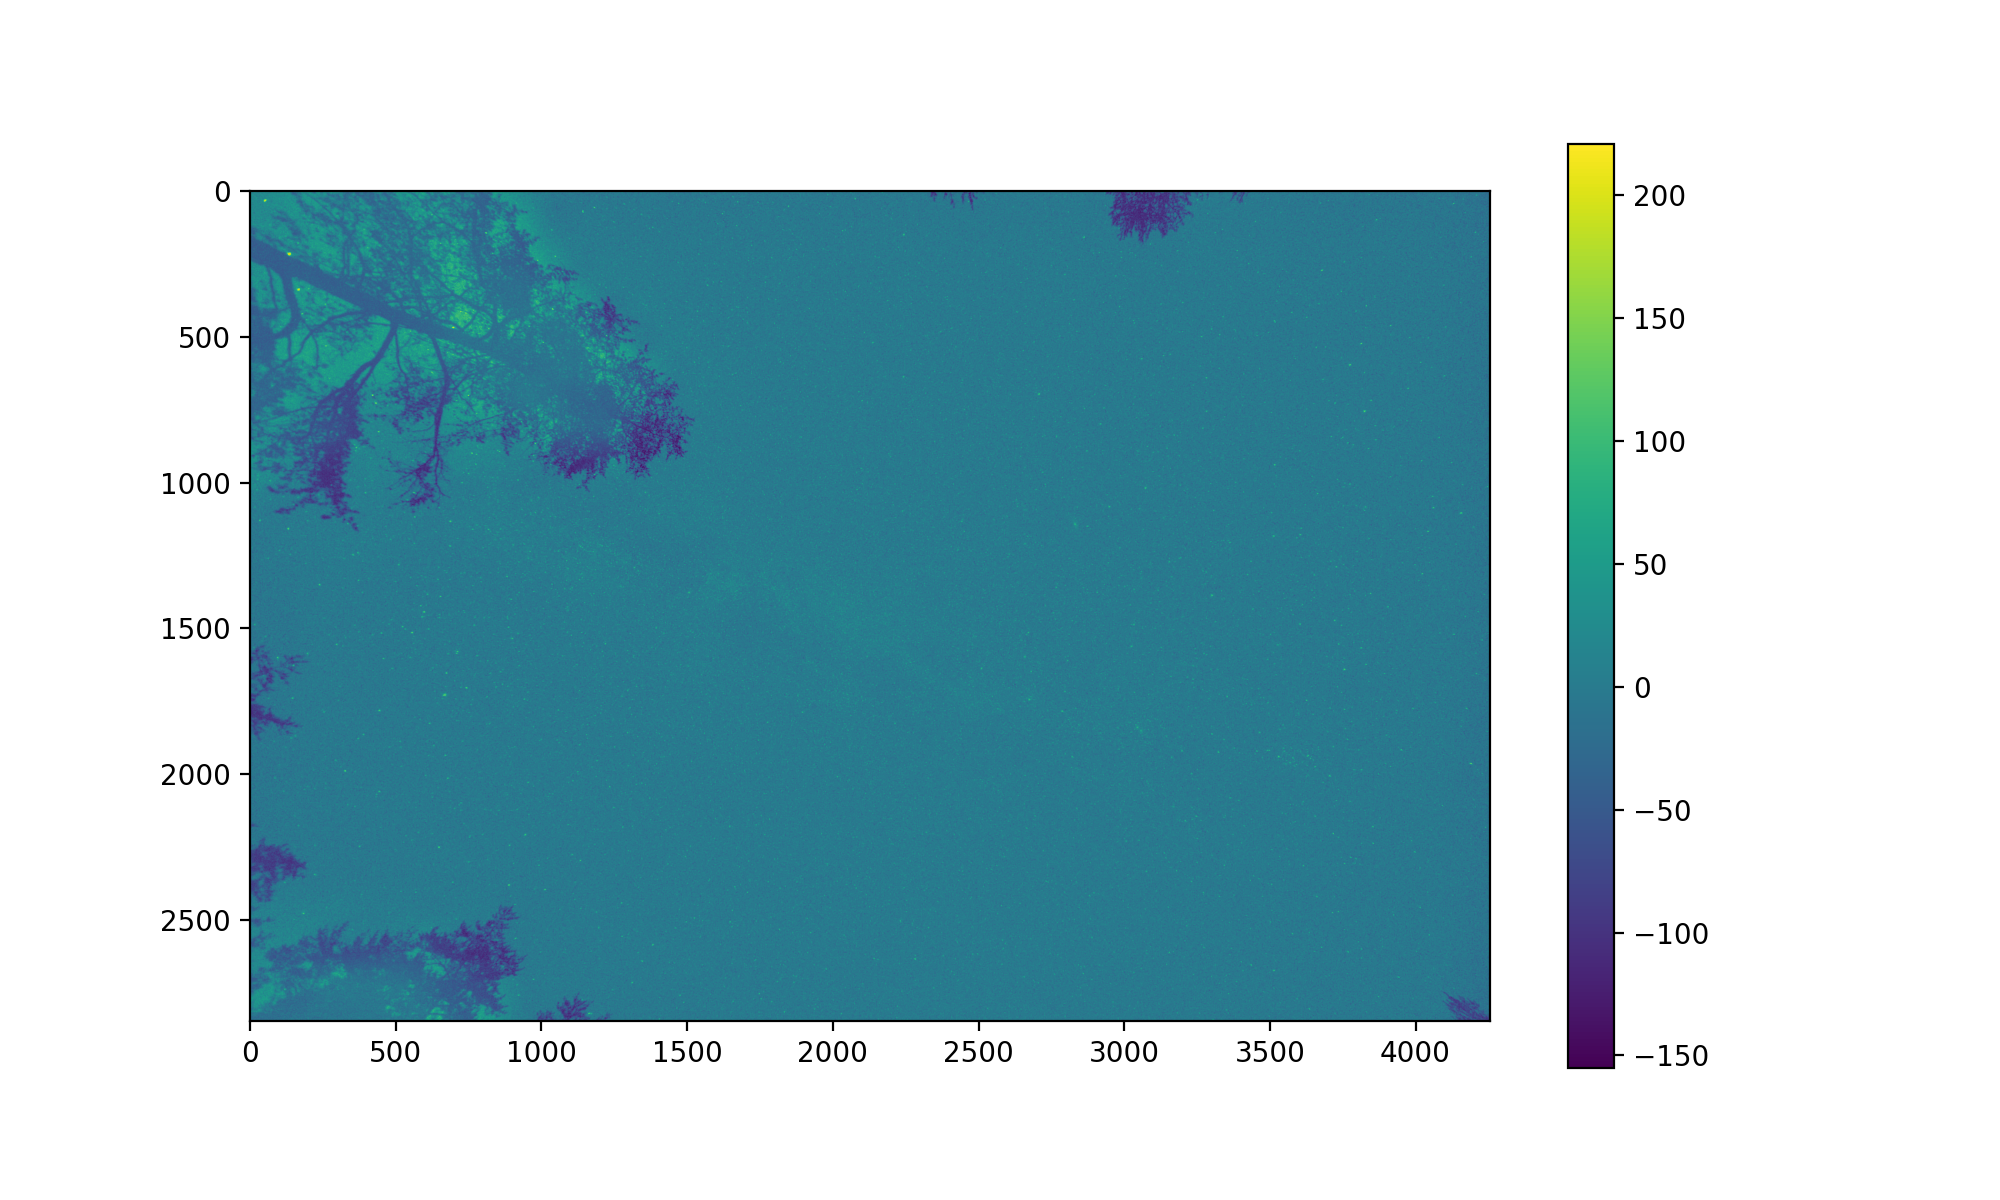

In [8]:
plt.figure(figsize=[10, 6])
plt.imshow(subtracted)
plt.colorbar()

In [9]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=7.0, threshold=18.*bkg.background_rms_median)  
sources = daofind(subtracted)  

# Must try find_peaks based on an input list.


In [10]:
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky    peak      flux        mag      
--- --------- --------- ---------- ... --- --------- --------- --------------
  1 2076.7463 25.966283  0.3639469 ...   0 117.28959 1.2363759    -0.23037629
  2 2466.4649 35.577544 0.43510168 ...   0 117.92073 1.2387672    -0.23247421
  3 1743.0325 37.839155 0.52087888 ...   0 118.52519 1.0059556  -0.0064470168
  4 4131.1326 42.144539 0.52965972 ...   0 158.60998 1.2982281    -0.28337751
  5 1847.8104 51.508711 0.39607129 ...   0 117.85724 1.1040738    -0.10749527
  6 1181.4752 56.180327 0.31681555 ...   0  125.8911 1.2270443    -0.22215063
  7 1142.4107 71.049919 0.35894686 ...   0 126.34662 1.1019325    -0.10538749
  8 1621.2891  77.31701 0.45574084 ...   0 118.64378 1.0726894   -0.076184963
  9 3866.5291 98.244066 0.47121083 ...   0 138.23219  1.145079    -0.14708865
 10 1670.2302 118.33855 0.50460045 ...   0  117.7248 1.0008738 -0.00094830198
...       ...       ...        ... ... ...       ...       ...  

<IPython.core.display.Javascript object>


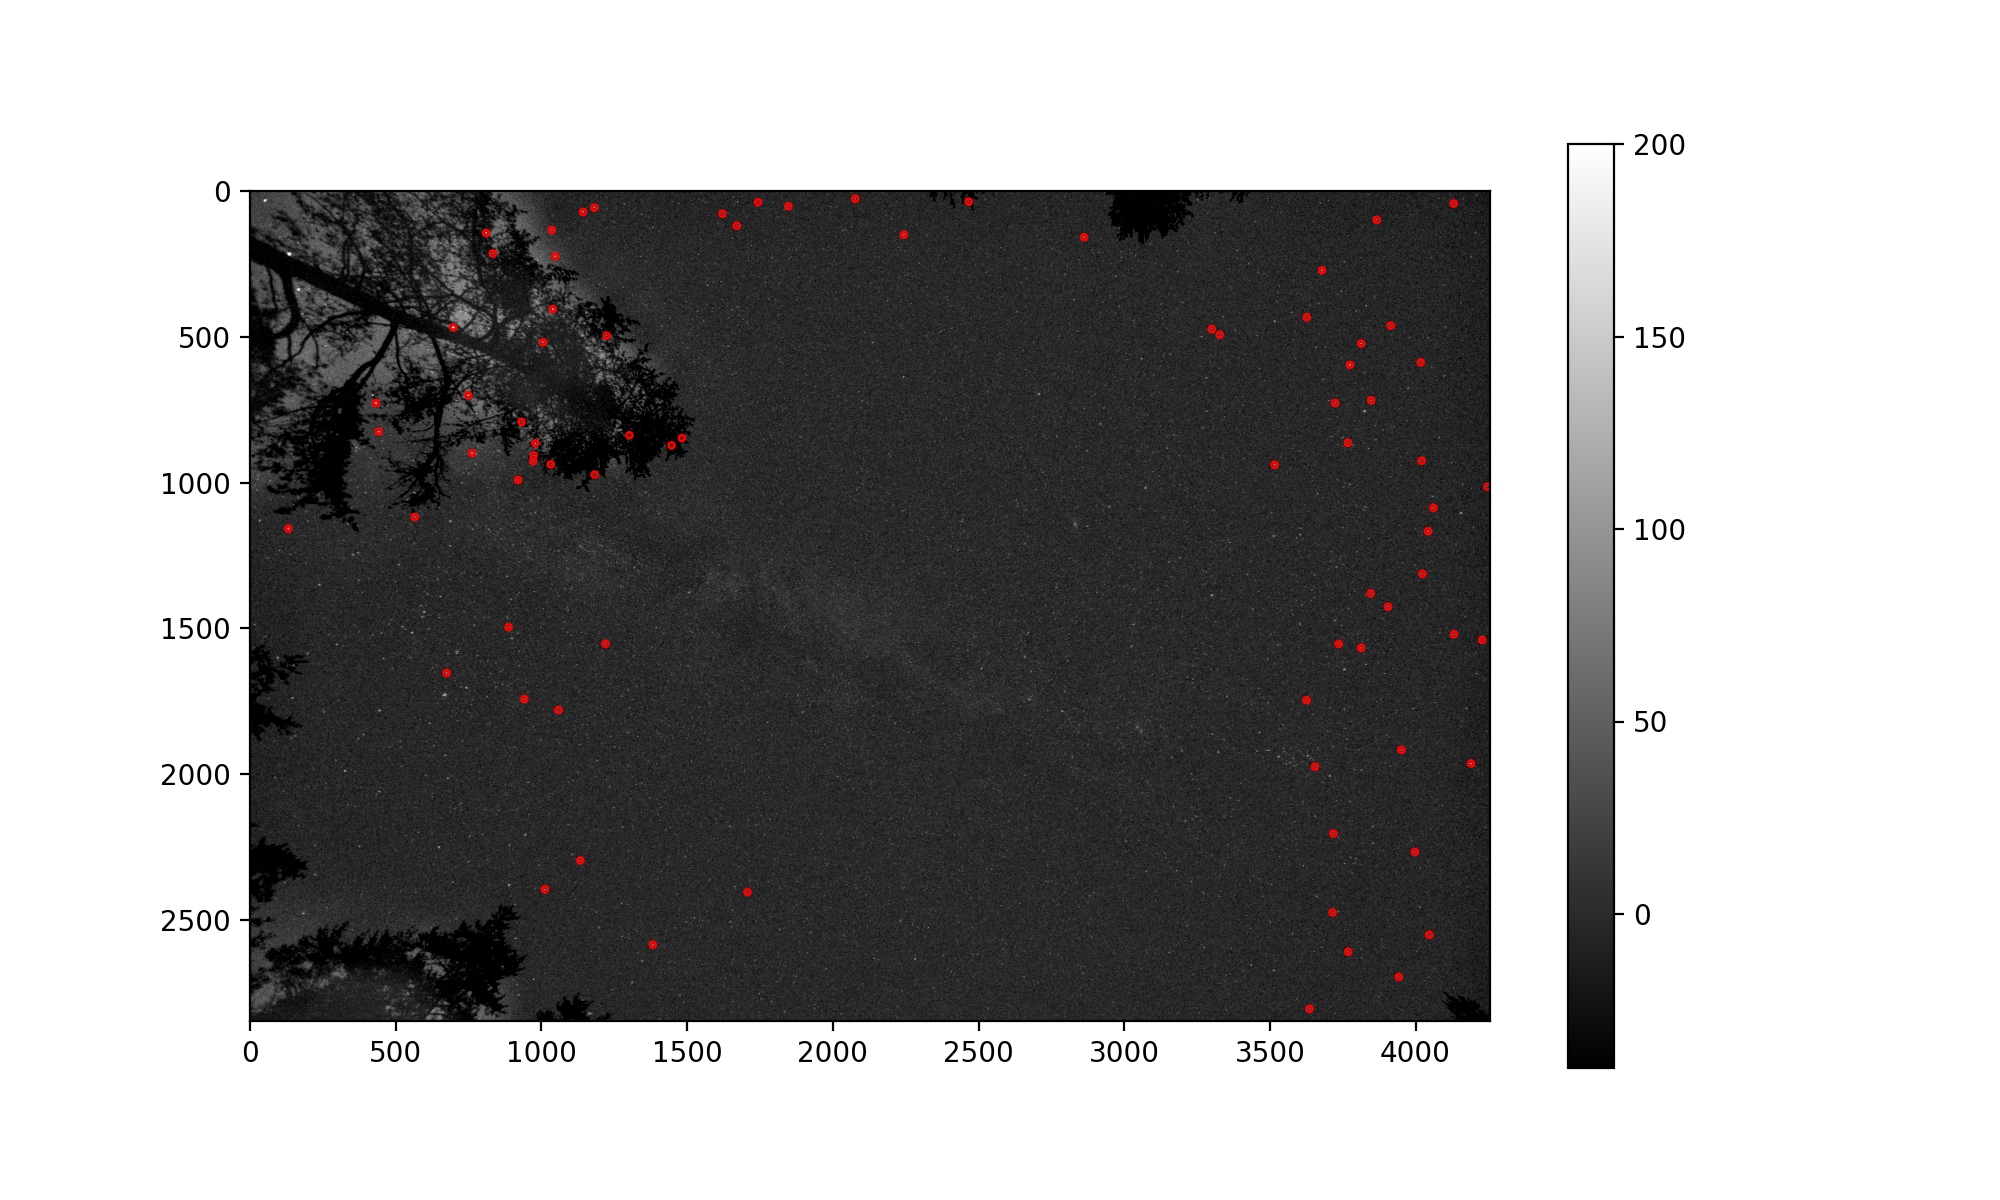

In [12]:
from photutils import CircularAperture
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
apertures = CircularAperture(positions, r=10.)
plt.figure(figsize=[10, 6])
plt.imshow(subtracted, vmin=-40, vmax=200, cmap=cm.gray)
plt.colorbar()
ap = apertures.plot(color='red')